# Homework 2

In [1]:
"""
Project members:
Weixi Yao (wy2350)
Kushal Wijesundara (kcw2144)
James Ding (jd3703)
Ryan McNally (rom2109)
"""

In [2]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
import surprise
import seaborn as sns
import matplotlib.pyplot as plt

from utility import *
from scipy import stats
from surprise import NMF
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from collections import defaultdict, Counter
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
%matplotlib inline

## Part 1: Business Objectives

**1. Our objective**
- The objective of this recommendation system is to increase users' experience/stickiness and ultimately their time spent on our site by making their search for the movies easier as well as by making them consistenly interested in our movie inventory. To achieve that, the recommendation system will provide a list of n (customizable, default 5 and we use 1 for this case study) movies to the users every time they log in, and the recommendation list will be a combination of movies that are most relevant to the users as well as the movies that are novel to the users.

**2. Other metrics we wish to optimize, in addition to accuracy**
- To echo back to the objective of our recommendation system, we will use item-coverage and novelty as the two metrics we optimize in addition to accuracy.
- Therefore, we will simultaneously optimize for coverage and novelty, the hypothesis being that a sufficiently diverse and new set of recommendations *with* a high accuracy will lead to deeper engagement, more time on the site, more clicks through the recommender, and will yield high quality data for improving the model in later stages.

**3. The intended user**
- The intended user for the business is any movie watcher & content consumer. Our objective is to maximize the engagement and personalization of this fundamental user. As a core piece of the user experience uplift strategy, this recommendation system intends to serve all users coming to our site to search for movies to watch, which means this recommendation system should be able to make recommendations to both new users and existing users. New users with little to no engagement data will be recommended very diverse and popular movies while their behavior and tastes become evident to the model over time.

**4. Business rules we think will be important**
- Never recommend items with less than 20% popularity. Our overall strategy will be to "discard" the movies that are the least popular, "maintain" the movies that are the most popular, and "boost" the movies that are in the middle of the popularity spectrum. 
- Always include the most popular movies in the recommendation to users who are at the bottom 25% in terms of activeness(measured by the number of movies rated). This will serve as a baseline cold-start strategy.
- Always recommend movies that the users have started but haven't finished if the relevant user data is accessible.
- Always recommend movies that are trending now. For example, recommend romance movies during Valentine's Day.
- Always include some level of novelty in the recommendations, meaning movies from different genres.

**5. Performance requirements**
- The time complexity of rating making should be O(kN), where N denotes the number of movie items.

**6. Notable sacrifices** 
   - As it pertains to the **final recommendation:** There is room for future improvement in testing the recommendation of unpopular movies on subsets of users, and then boosting them pending positive feedback. As it stands, we require a critical mass of ratings for a film to be considered for recommendation by the model (20th percentile of ratings received). A new movie that is never recommended has no hope of getting to that critical mass. 
   - As it pertains to **optimazation and accuracy:** We are willing to sacrifice maximal 'accuracy' for the deeper and broader goal of attaining a holistic understanding of our users and their tastes. A maximally accurate but non-novel or high-coverage model might converge and recommend the user's favorite movie back to them n times repeatedly; the chances of a user remaining on the site or clicking through over and over in that situation are low.
   - As it pertains to **data sampling for model building:** Our sampling method biases for existing popularity, this will ignore currently unpopular users and movies (<50th percentile in the dataset). This is mainly for ensuring richness of signal in the final model which will be recommending *to* sparse datapoint users. This is a business decision, we would rather have a functional beta model to begin with than to erroneously recommend movies with a low network effect, at least for an inital v1. We cannot let the perfect be the enemy of the good. (We delve into tuning this parameter in Part 6 with impacts on training performance and model performance.)

## Part 2: Exploratory Data Analysis and Two models building

Based on the instructions, we downloaded the entire movie data set at https://grouplens.org/datasets/movielens/latest/ with 27M ratings
for exploratory data analysis. Within the movie data, the ratings data set consists of 'userids', 'movieids', 'ratings' and 'timestamp' along with the  the movies dataset, which consists of 'movieids', 'titles' and 'genres'. 

In [3]:
# load the data set for full ratings
ratings = pd.read_csv('./ml-latest/ratings.csv', 
                      usecols=['userId', 'movieId', 'rating'],
                      dtype={'user|Id':'int32', 'movieId':'int32', 'rating':'float128'},
                      sep=',')
movies = pd.read_csv('./ml-latest/movies.csv',
                    dtype={'movieId':'int32'})
print("number of distinct participated users: ", ratings['userId'].nunique())
print("number of distinct rated movies: ", ratings['movieId'].nunique())

number of distinct participated users:  283228
number of distinct rated movies:  53889


In [4]:
# merge data
movie_ratings = ratings.merge(movies, on = 'movieId', how = 'inner')
# numerical data statistics
movie_ratings.describe(include='number').transpose()

,count,mean,std,min,25%,50%,75%,max
userId,27753444.0,141942.015571,81707.400091,1.0,71176.0,142022.0,212459.0,283228.0
movieId,27753444.0,18487.999834,35102.625248,1.0,1097.0,2716.0,7150.0,193886.0
rating,27753444.0,3.530445,1.066353,0.5,3.0,3.5,4.0,5.0


In [5]:
#categorical data statistics
movie_ratings.describe(include='object').transpose()

,count,unique,top,freq
title,27753444,53817,"Shawshank Redemption, The (1994)",97999
genres,27753444,1610,Drama,1959338


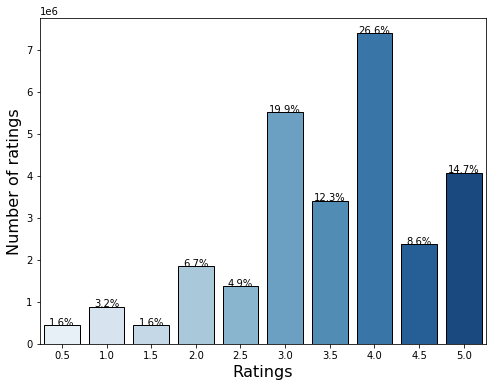

In [6]:
plt.figure(figsize = (8,6))
ax = sns.countplot(data = movie_ratings,x='rating', palette = 'Blues', edgecolor = 'Black')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Ratings', fontsize = 16)
plt.ylabel('Number of ratings', fontsize = 16)
total = float(len(movie_ratings))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 5,
            '{:1.1f}%'.format(100*height/total),
            ha = 'center')
plt.show()

The distribution of the ratings for the entire data set is shown above. It presents a negatively skewed distribution where the mean rating and median is above 3. (note: Number of ratings in millions)

For experiment and development purposes, we will extract a small subset of users and movie items from the "full" dataset.

We will first select ~1000 items and ~25000 users for model development and we will then select ~200 items and ~1500 users from the development set for testing purposes.

The methodology of selecting these users and items will be discussed in the data exploration section.

**Data exploration and dataset sampling**

Understanding how the data is distributed is crucial for designing the subsampling strategy and we believe that, in a real world setting, data collected from explicit feedbacks like ratings can be very sparse and data points are mostly collected from very popular movies and highly active users.

The following data exploration will justify our hypothesis.

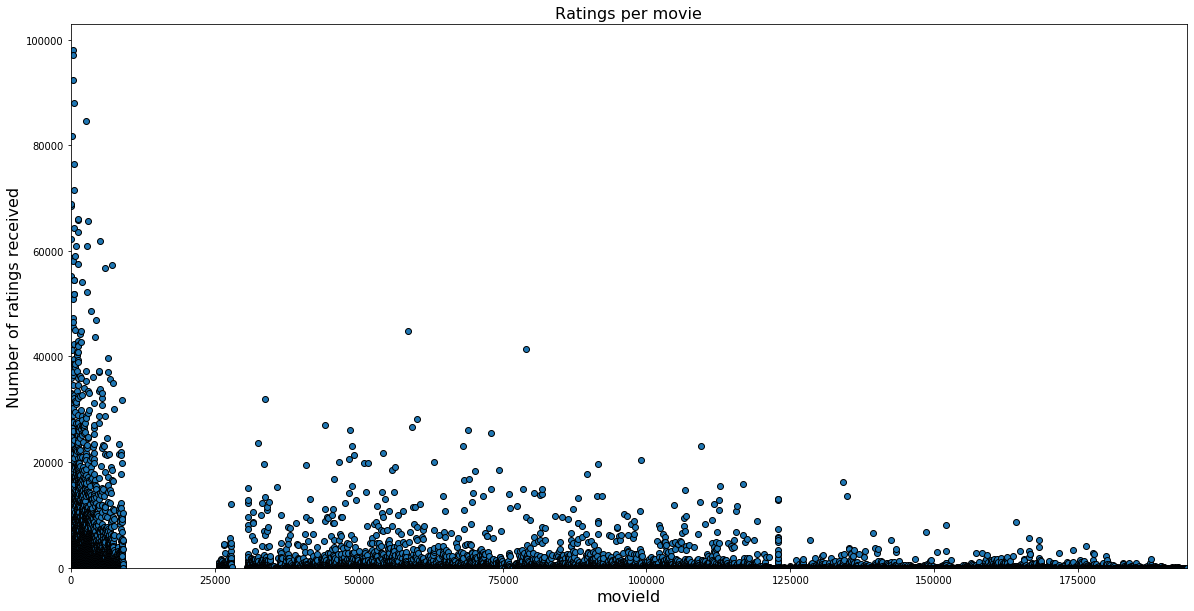

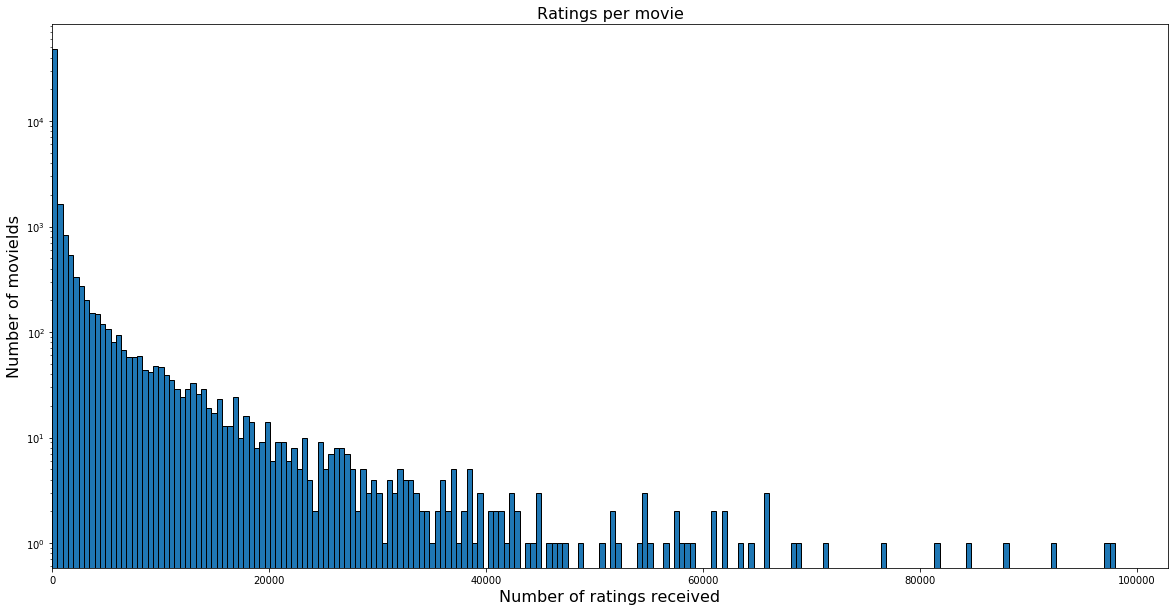

In [7]:
# visualize the popularity by each movie
movie_popularity = ratings[['userId', 'movieId']].groupby('movieId').count()
movie_popularity.columns=['num_ratings']
plt.figure(figsize=(20, 10))
plt.scatter(movie_popularity.index, 
            movie_popularity.num_ratings, 
            edgecolor='black')
plt.xlim(0, movie_popularity.index.max())
plt.ylim(0,)
plt.title('Ratings per movie', fontsize = 16)
plt.xlabel('movieId', fontsize = 16)
plt.ylabel('Number of ratings received', fontsize = 16)
plt.show()

# visualize the distribution of the popularity across all movies
plt.figure(figsize=(20, 10))
plt.hist(movie_popularity.num_ratings, 
         bins=200, 
         edgecolor='black', 
         log=True)
plt.title('Ratings per movie', fontsize = 16)
plt.xlabel('Number of ratings received', fontsize = 16)
plt.ylabel('Number of movieIds', fontsize = 16)
plt.xlim(0,)
plt.show()

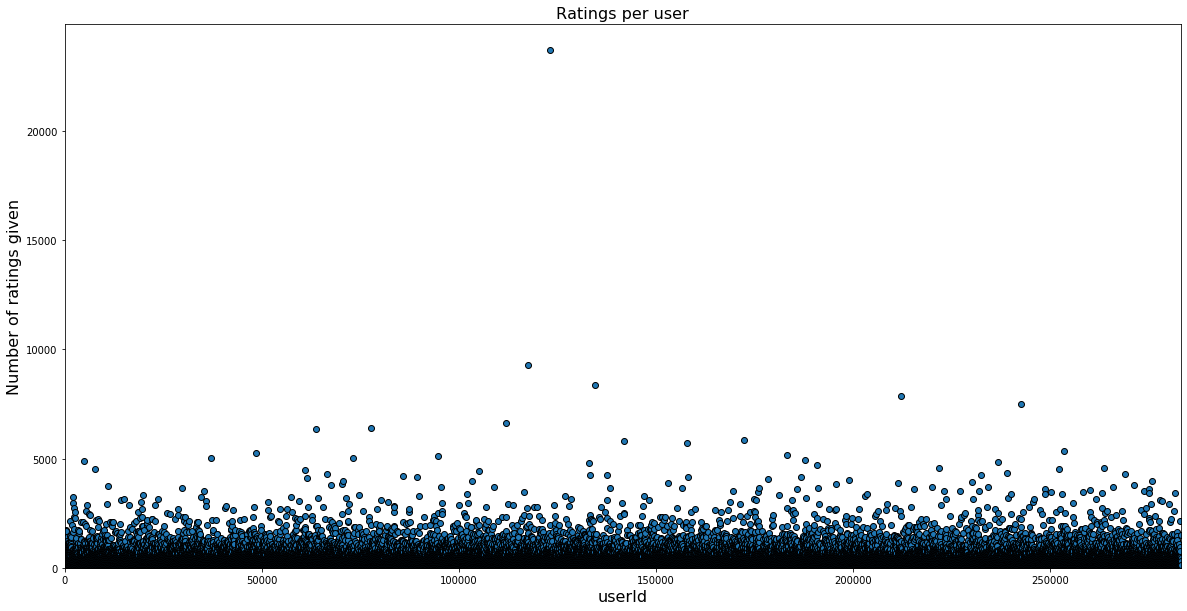

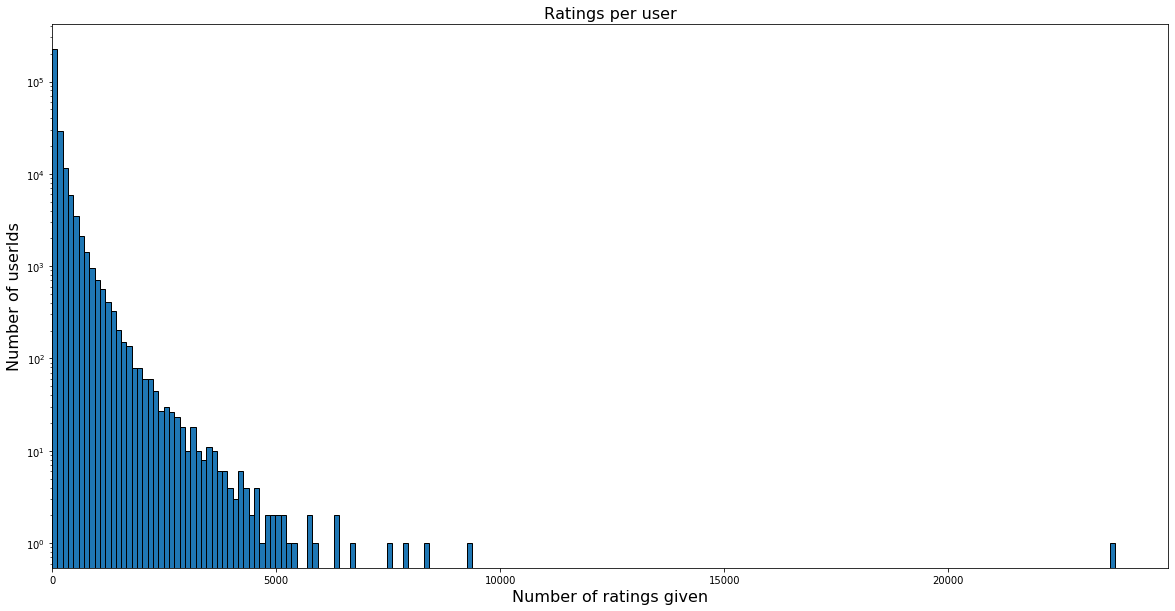

In [8]:
# visualize the popularity by each movie
user_activeness = ratings[['userId', 'movieId']].groupby('userId').count()
user_activeness.columns=['num_ratings']
plt.figure(figsize=(20, 10))
plt.scatter(user_activeness.index, 
            user_activeness.num_ratings, 
            edgecolor='black')
plt.xlim(0, user_activeness.index.max())
plt.ylim(0,)
plt.title('Ratings per user', fontsize = 16)
plt.xlabel('userId', fontsize = 16)
plt.ylabel('Number of ratings given', fontsize = 16)
plt.show()

# visualize the distribution of the popularity across all movies
plt.figure(figsize=(20, 10))
plt.hist(user_activeness.num_ratings, 
         bins=200, 
         edgecolor='black', 
         log=True)
plt.title('Ratings per user', fontsize = 16)
plt.xlabel('Number of ratings given', fontsize = 16)
plt.ylabel('Number of userIds', fontsize = 16)
plt.xlim(0,)
plt.show()

- The graphs above preliminarily confirm our assumptions regarding the distribution of the number of ratings received per movie and the distribution of the number of ratings given per user with a few particularly enthusiastic viewers, which are two extremely long-tailed distributions. Based on this observation, we ideally want to draw a subset of movie items and users that can represent the original dataset without giving unrealistically good or bad experiment results.


- We specifically want to get rid of the movies whose popularity is at the bottom 50 percentile, because we believe that there is a high possibility that those movies are only favored by an extremely small group of users, and more importantly, that the average ratings received by those movies are more likely to be biased. The same strategy also applies to users.


- For example, if certain movies are rated only once and received an average rating of 5, in an item-based collaborative filtering model, those movies will accidentally become part of the recommendations for many if not all users, which is not ideal. 

**Create a subset of dataset, save it for performance measurement**

In [9]:
ratings_full = sample_dateset_by_percentile(ratings, 25000, 1000)
print("number of distinct participated users (full): ", ratings_full['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_full['movieId'].nunique())

number of distinct participated users (full):  24511
number of distinct rated movies (full):  1000


In [10]:
reader = Reader()
data_full = Dataset.load_from_df(ratings_full[['userId', 
                                               'movieId', 
                                               'rating']], 
                                 reader=reader)

**Create a subset of dataset, save it for development**

In [11]:
ratings_sub = sample_dateset_by_percentile(ratings_full, 1500, 200)
print("number of distinct participated users (subset): ", ratings_sub['userId'].nunique())
print("number of distinct rated movies (subset): ", ratings_sub['movieId'].nunique())

number of distinct participated users (subset):  1487
number of distinct rated movies (subset):  200


In [12]:
reader = Reader()
data_sub = Dataset.load_from_df(ratings_sub[['userId', 
                                             'movieId', 
                                             'rating']], 
                                reader=reader)

After careful manipulation, we have successfully keep 1487 users from top active levels and 200 movie items from top popularity levels, for development purposes.

### Part 2.1: Item-based neighborhood method

In [13]:
trainvalset, testset = train_test_split(data_sub, test_size=0.2)

In [14]:
# baseline modeling constructing
item_model = KNNWithMeans(k=4, sim_options={'name': 'pearson', 
                                            'user_based': False, 
                                            'verbose' : False})

In [15]:
item_model.fit(trainvalset);

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [16]:
uid = str(699)
iid = str(296)
item_model_pred = item_model.predict(uid, 
                                     iid, 
                                     verbose=False)
print("Prediction for rating: ", item_model_pred)

Prediction for rating:  user: 699        item: 296        r_ui = None   est = 3.49   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


- In this project, we’ll use the surprise package, a popular package for building recommendation systems in Python. 

- At this part, we have sucessfully built and tested a baseline item-based neighborhood model by making a demo rating pradiction for user 699 and item 296.

- The item-based neighborhood model built above uses pearson as the similarity metric and considers the ratings of four closest neighbors while making predictions.

### Part 2.2: Matrix Factorization

In [17]:
# baseline model constructing
NMF_model = NMF(n_factors=20, 
                n_epochs=10, 
                biased=True)

In [18]:
NMF_model.fit(trainvalset);

In [19]:
uid = str(699)
iid = str(296)
NMF_model_pred = NMF_model.predict(uid, 
                                   iid,
                                   verbose=False)
print("Prediction for rating: ", NMF_model_pred)

Prediction for rating:  user: 699        item: 296        r_ui = None   est = 3.49   {'was_impossible': False}


- At this part, we have sucessfully built and tested a baseline matrix factorization model(NMF) by making a demo rating pradiction for user 699 and item 296.

- The NMF model built above decomposes the characteristic matrix in latent space size of 20.

## Part 3: Model evaluation

### Part 3.1.1: CV setup for item-based neighborhood method

For this task, we will use **RMSE(Root Mean Squared Error)** as the primary accuracy metric and **MAE(Mean Absolute Error)** as the secondary accuracy metric.

In [20]:
# Run 5-fold cross-validation and print results
result = cross_validate(item_model, 
                        data_full, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9448  0.9478  0.9566  0.9518  0.9558  0.9514  0.0045  
MAE (testset)     0.7128  0.7154  0.7207  0.7203  0.7225  0.7184  0.0037  
RMSE (trainset)   0.4180  0.4189  0.4174  0.4193  0.4185  0.4184  0.0007  
MAE (trainset)    0.3128  0.3130  0.3121  0.3135  0.3127  0.3128  0.0004  
Fit time          0.91    0.98    0.99    1.00    1.01    0.98    0.03    
Test time         2.13    2.07    2.18    2.13    2.11    2.12    0.04    


The results above give an preliminary review of how well the model fits the training set as well as how well the model generalizes on the test set. According to the results above, the **average testset RMSE is 0.95** and the **average testset MAE is 0.72**.

### Part 3.1.2: Coverage of item-based neighborhood method

In [21]:
trainvalset, testset = train_test_split(data_sub, test_size=0.2)
trainvalset_testfy = trainvalset.build_anti_testset()

In [22]:
user_list_train = set(trainvalset.all_users())
user_list_test = set([item[0] for item in testset])

item_list_train = set(trainvalset.all_items())
item_list_test = set([item[1] for item in testset])

In [23]:
item_model.fit(trainvalset);

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [24]:
predictions_train = item_model.test(trainvalset_testfy)
predictions_test = item_model.test(testset)

top_n_train = get_top_n(predictions_train, n=1)
top_n_test = get_top_n(predictions_test, n=1)

In [25]:
recommendation_train = []
# Print the recommended items for each user
for uid, user_ratings in top_n_train.items():
    recommendation_train.append([iid for (iid, _) in user_ratings])
    
recommendation_train_list = []
for rec_list in recommendation_train:
    for item in rec_list:
        recommendation_train_list.append(item)
recommendation_train_list = set(recommendation_train_list)

In [26]:
recommendation_test = []
# Print the recommended items for each user
for uid, user_ratings in top_n_test.items():
    recommendation_test.append([iid for (iid, _) in user_ratings])

recommendation_test_list = []
for rec_list in recommendation_test:
    for item in rec_list:
        recommendation_test_list.append(item)
recommendation_test_list = set(recommendation_test_list)

In [27]:
print('coverage on train set', '{:.2f}'.format(len(recommendation_train_list)/len(item_list_train)))
print('coverage on test set', '{:.2f}'.format(len(recommendation_test_list)/len(item_list_test)))

coverage on train set 0.31
coverage on test set 0.66


- As we can see with the above discrepancy in coverage between the train and test sets, our recommender is converging on a few top performers in the train set but is more dispersed in the test set. We will test this hypothesis below by checking how often, on a percentage basis, the top movies were recommended in each case. 
- With the lower coverage, we would expect that the top recommendations are recommended more often in the train set.

In [28]:
train_counter = pd.DataFrame(Counter([item for sublist in  recommendation_train for item in sublist]).most_common(),columns=['movie_id','count'])
train_counter['pct_recommended'] = train_counter['count']/len(recommendation_train)
test_counter = pd.DataFrame(Counter([item for sublist in  recommendation_test for item in sublist]).most_common(),columns=['movie_id','count'])
test_counter['pct_recommended'] = test_counter['count']/len(recommendation_test)

In [29]:
train_counter.join(movies).head()[['title','count','pct_recommended']]

,title,count,pct_recommended
0,Toy Story (1995),702,0.482474
1,Jumanji (1995),184,0.126460
2,Grumpier Old Men (1995),80,0.054983
3,Waiting to Exhale (1995),55,0.037801
4,Father of the Bride Part II (1995),45,0.030928


In [30]:
test_counter.join(movies).head()[['title','count','pct_recommended']]

,title,count,pct_recommended
0,Toy Story (1995),205,0.215789
1,Jumanji (1995),50,0.052632
2,Grumpier Old Men (1995),42,0.044211
3,Waiting to Exhale (1995),35,0.036842
4,Father of the Bride Part II (1995),34,0.035789


- Our hypothesis is confirmed, we see that the test case recommended the most popular title (Toy Story) 19.89% of the time , while the train set was recommended it over 28.6% of the time. 
- The discrepancy is driven by the 'richer rich' effect of the top performers nabbing the n=1 top spot.
- The next hypothesis will be to increase n to 5 and we will ideally see higher coverage in both sets, and *relative* closer parity between coverages. 

In [31]:
predictions_train = item_model.test(trainvalset_testfy)
predictions_test = item_model.test(testset)

#new hypothesis n=5
top_n_train = get_top_n(predictions_train, n=5)
top_n_test = get_top_n(predictions_test, n=5)

recommendation_train = []
# Print the recommended items for each user
for uid, user_ratings in top_n_train.items():
    recommendation_train.append([iid for (iid, _) in user_ratings])
    
recommendation_train_list = []
for rec_list in recommendation_train:
    for item in rec_list:
        recommendation_train_list.append(item)
recommendation_train_list = set(recommendation_train_list)

recommendation_test = []
# Print the recommended items for each user
for uid, user_ratings in top_n_test.items():
    recommendation_test.append([iid for (iid, _) in user_ratings])

recommendation_test_list = []
for rec_list in recommendation_test:
    for item in rec_list:
        recommendation_test_list.append(item)
recommendation_test_list = set(recommendation_test_list)

print('coverage on train set', '{:.2f}'.format(len(recommendation_train_list)/len(item_list_train)))
print('coverage on test set', '{:.2f}'.format(len(recommendation_test_list)/len(item_list_test)))

coverage on train set 0.58
coverage on test set 0.94


In [32]:
train_counter = pd.DataFrame(Counter([item for sublist in  recommendation_train for item in sublist]).most_common(),columns=['movie_id','count'])
train_counter['pct_recommended'] = train_counter['count']/len(recommendation_train)
test_counter = pd.DataFrame(Counter([item for sublist in  recommendation_test for item in sublist]).most_common(),columns=['movie_id','count'])
test_counter['pct_recommended'] = test_counter['count']/len(recommendation_test)

In [33]:
train_counter.join(movies).head()[['title','count','pct_recommended']]

,title,count,pct_recommended
0,Toy Story (1995),1121,0.770447
1,Jumanji (1995),683,0.469416
2,Grumpier Old Men (1995),641,0.440550
3,Waiting to Exhale (1995),504,0.346392
4,Father of the Bride Part II (1995),483,0.331959


In [34]:
test_counter.join(movies).head()[['title','count','pct_recommended']]

,title,count,pct_recommended
0,Toy Story (1995),236,0.248421
1,Jumanji (1995),91,0.095789
2,Grumpier Old Men (1995),65,0.068421
3,Waiting to Exhale (1995),57,0.060000
4,Father of the Bride Part II (1995),56,0.058947


**Explanation:**

- The disparity between train and test speaks to potential overfitting of this model, higher coverage is desirable but is likely being seen in this case because the model is much more unsure of what it is meant to recommend on unseen users.

- While there is potentially a degree of overfitting, we are encouraged by the fact that the same top performaers are recommended in each case and in the same order, just with varying frequencies. 

- The best remedy for this is to either regularize the model and penalize convergence in the train set more, but this is sub-optimal in practice. We would much rather see more user data to enrich the model further by adding more features, rather than penalize the model for high bias low variance. 

### Part 3.2.1: CV setup for Matrix Factorization

In [35]:
# Run 5-fold cross-validation and print results
result = cross_validate(NMF_model, 
                        data_full, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2685  1.1939  1.2576  1.6450  1.2616  1.3253  0.1621  
MAE (testset)     0.9699  0.9032  0.9582  1.2853  0.9595  1.0152  0.1371  
RMSE (trainset)   1.2603  1.1729  1.2408  1.6512  1.2408  1.3132  0.1716  
MAE (trainset)    0.9617  0.8822  0.9443  1.2879  0.9394  1.0031  0.1449  
Fit time          3.96    3.92    3.92    4.06    4.08    3.99    0.07    
Test time         0.44    0.43    0.57    0.57    0.42    0.49    0.07    


The results above give an preliminary review of how well the model fits the training set as well as how well the model generalizes on the test set. According to the results above, the **average testset RMSE is 1.185** and the **average testset MAE is 0.897**.

### Part 3.2.2: Coverage of Matrix Factorization

In [36]:
NMF_model.fit(trainvalset);

In [37]:
predictions_train = NMF_model.test(trainvalset_testfy)
predictions_test = NMF_model.test(testset)

top_n_train = get_top_n(predictions_train, n=1)
top_n_test = get_top_n(predictions_test, n=1)

In [38]:
recommendation_train = []
# Print the recommended items for each user
for uid, user_ratings in top_n_train.items():
    recommendation_train.append([iid for (iid, _) in user_ratings])
    
recommendation_train_list = []
for rec_list in recommendation_train:
    for item in rec_list:
        recommendation_train_list.append(item)
recommendation_train_list = set(recommendation_train_list)

In [39]:
recommendation_test = []
# Print the recommended items for each user
for uid, user_ratings in top_n_test.items():
    recommendation_test.append([iid for (iid, _) in user_ratings])
    
recommendation_test_list = []
for rec_list in recommendation_test:
    for item in rec_list:
        recommendation_test_list.append(item)
recommendation_test_list = set(recommendation_test_list)

In [40]:
print('coverage on train set', '{:.2f}'.format(len(recommendation_train_list)/len(item_list_train)))
print('coverage on test set', '{:.2f}'.format(len(recommendation_test_list)/len(item_list_test)))

coverage on train set 0.12
coverage on test set 0.73


In [41]:
train_counter = pd.DataFrame(Counter([item for sublist in  recommendation_train for item in sublist]).most_common(),columns=['movie_id','count'])
train_counter['pct_recommended'] = train_counter['count']/len(recommendation_train)
test_counter = pd.DataFrame(Counter([item for sublist in  recommendation_test for item in sublist]).most_common(),columns=['movie_id','count'])
test_counter['pct_recommended'] = test_counter['count']/len(recommendation_test)

In [42]:
train_counter.join(movies).head()[['title','count','pct_recommended']]

,title,count,pct_recommended
0,Toy Story (1995),629,0.432302
1,Jumanji (1995),424,0.291409
2,Grumpier Old Men (1995),257,0.176632
3,Waiting to Exhale (1995),26,0.017869
4,Father of the Bride Part II (1995),22,0.015120


In [43]:
test_counter.join(movies).head()[['title','count','pct_recommended']]

,title,count,pct_recommended
0,Toy Story (1995),208,0.218947
1,Jumanji (1995),47,0.049474
2,Grumpier Old Men (1995),44,0.046316
3,Waiting to Exhale (1995),35,0.036842
4,Father of the Bride Part II (1995),31,0.032632


- Here we see we have much the same effect as with matrix factorization as we do with kNN. Higher coverage on test than train, and concentration among top performers in train. 

- Below we run the same experiment, increasing n to 5:

In [44]:
top_n_train = get_top_n(predictions_train, n=5)
top_n_test = get_top_n(predictions_test, n=5)

recommendation_train = []
# Print the recommended items for each user
for uid, user_ratings in top_n_train.items():
    recommendation_train.append([iid for (iid, _) in user_ratings])
    
recommendation_train_list = []
for rec_list in recommendation_train:
    for item in rec_list:
        recommendation_train_list.append(item)
recommendation_train_list = set(recommendation_train_list)

recommendation_test = []
# Print the recommended items for each user
for uid, user_ratings in top_n_test.items():
    recommendation_test.append([iid for (iid, _) in user_ratings])
    
recommendation_test_list = []
for rec_list in recommendation_test:
    for item in rec_list:
        recommendation_test_list.append(item)
recommendation_test_list = set(recommendation_test_list)

print('coverage on train set', '{:.2f}'.format(len(recommendation_train_list)/len(item_list_train)))
print('coverage on test set', '{:.2f}'.format(len(recommendation_test_list)/len(item_list_test)))

coverage on train set 0.24
coverage on test set 0.97


In [45]:
train_counter = pd.DataFrame(Counter([item for sublist in  recommendation_train for item in sublist]).most_common(),columns=['movie_id','count'])
train_counter['pct_recommended'] = train_counter['count']/len(recommendation_train)
test_counter = pd.DataFrame(Counter([item for sublist in  recommendation_test for item in sublist]).most_common(),columns=['movie_id','count'])
test_counter['pct_recommended'] = test_counter['count']/len(recommendation_test)

In [46]:
train_counter.join(movies).head()[['title','count','pct_recommended']]

,title,count,pct_recommended
0,Toy Story (1995),1360,0.934708
1,Jumanji (1995),1342,0.922337
2,Grumpier Old Men (1995),1308,0.898969
3,Waiting to Exhale (1995),1231,0.846048
4,Father of the Bride Part II (1995),508,0.349141


In [47]:
test_counter.join(movies).head()[['title','count','pct_recommended']]

,title,count,pct_recommended
0,Toy Story (1995),235,0.247368
1,Jumanji (1995),91,0.095789
2,Grumpier Old Men (1995),65,0.068421
3,Waiting to Exhale (1995),58,0.061053
4,Father of the Bride Part II (1995),58,0.061053


**Explanation:**

- As with kNN, the explanation here is that the model has higher likelihood of recommending a random movie in the test dataset than the train dataset.

## Part 4: GridSearch

### Part 4.1: GS setup for item-based neighborhood method

In [48]:
param_grid = {'k': [2, 6, 10, 14, 18, 20, 50, 100]}

In [49]:
gs = GridSearchCV(KNNWithMeans, 
                  param_grid, 
                  measures=['RMSE', 'MAE'], 
                  cv=5)

In [50]:
gs.fit(data_sub);

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [51]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [52]:
n_k = results_df['param_k']
mae_results = results_df['mean_test_mae']
rmse_results = results_df['mean_test_rmse']

In [53]:
# best RMSE score
print('Best RMSE', '{:f}'.format(gs.best_score['rmse']))
print('BEST MAE', '{:f}'.format(gs.best_score['mae']))

Best RMSE 0.992959
BEST MAE 0.759395


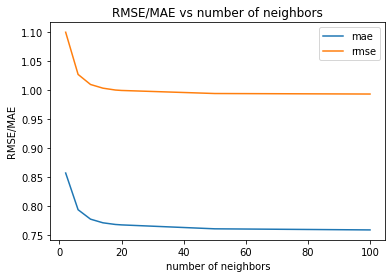

In [54]:
fig, ax = plt.subplots()
ax.plot(n_k, mae_results, label='mae');
ax.plot(n_k, rmse_results, label='rmse');
ax.set_title('RMSE/MAE vs number of neighbors')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('RMSE/MAE')
ax.legend();

**Explanation:**
- As we can see from the results above, as the number of neighbors increases, both of the accuracy measures decrease. This makes sense because as the model considers more items(neighbors) while making predictions, the model becomes more capable of making more accurate predictions.
- Although we haven't reached the optimal RMSE/MAE in this grid, we would say the **best number of neighbors is roughly 15**:
 - We come to the above conclusion taking performance into account, there is a diminishing return on computation power vs incremental improvement in the error term. Depending on the frequency this model will refresh against the amount of time/energy/memory it will take to do so, we think 15 is a reasonable number on these grounds. 
 - Adding more neighbors is not a cure-all either, too few neighbors and you might miss the 'cluster' you're trying to participate in, too many neighbors and you can shift your mean away from a strong-signal cluster with relatively few peers and this can actually increase error on a case-by-case basis but will smooth out the error over the full model. 
  * Imagine the qualitative neighbors of a movie like *Rocky Horror Picture Show*... there aren't many. So a modest k is ideal here. Setting it exhorbitantly high will approach a utilitarian model of 'the least bad recommendation for the most people' but offers very little of the personalization we are after here.
 - Thus it is normally recommended to pick a k near the inflection point where the error term levels off. We endorse this notion in our proposal. 

### Part 4.2: GS setup for Matrix Factorization

In [55]:
param_grid = {'n_factors': [10, 30, 50, 70, 90]}

In [56]:
gs = GridSearchCV(NMF, 
                  param_grid, 
                  measures=['RMSE', 'MAE'], 
                  cv=5)

In [57]:
gs.fit(data_sub)

In [58]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [59]:
n_factors = results_df['param_n_factors']
mae_results = results_df['mean_test_mae']
rmse_results = results_df['mean_test_rmse']

In [60]:
# best RMSE score
print('Best RMSE', '{:f}'.format(gs.best_score['rmse']))
print('BEST MAE', '{:f}'.format(gs.best_score['mae']))

Best RMSE 1.019010
BEST MAE 0.776370


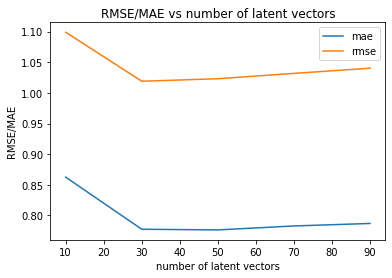

In [61]:
fig, ax = plt.subplots()
ax.plot(n_factors, mae_results, label='mae');
ax.plot(n_factors, rmse_results, label='rmse');
ax.set_title('RMSE/MAE vs number of latent vectors')
ax.set_xlabel('number of latent vectors')
ax.set_ylabel('RMSE/MAE')
ax.legend();

**Explanation:**
- As we can see from the results above, as the number of latent vectors increases, both of the accuracy measures decrease. This makes sense because the matrix factorization algorithm re-constructs the true matrix more accurately with higher latent vector size.

- **The best size of latent space is 30**

## Part 5: Other design

There are two key observations arise from the above section:

1. Models with higher complexity usually perform better.
    - According to the grid-search results, the "accuracy" of the models increase as the number of latent vectors/number of neighbors increase. Therefore, if we want to further increase the accuracy of the baseline models built previously, we should definitely construct models with reasonably high complexity.



2. The test set's coverage of the more "accurate" model is lower.
    - The tradeoff with complexity is overfitting. We love accuracy and low error, but we are looking to learn holistic functions about our dataset, not memorize it. There is a significant inflection point around the 30 feature latent space range, hence our decision to parameterize our model on that point. 
 

## Part 6: Sample size modification

### Part 6.1: 25%

In [62]:
ratings_25 = sample_dateset_by_percentile(ratings, 8000, 250)
print("number of distinct participated users (full): ", ratings_25['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_25['movieId'].nunique())

number of distinct participated users (full):  6370
number of distinct rated movies (full):  250


In [63]:
reader = Reader()
data_25 = Dataset.load_from_df(ratings_25[['userId', 
                                           'movieId', 
                                           'rating']], 
                               reader=reader)

**rebuild the model using the best paramter**

In [64]:
# rebuild the model using the best paramter
item_model = KNNWithMeans(k=15, 
                          sim_options={'name': 'pearson', 
                                       'user_based': False, 
                                       'verbose' : False})

In [65]:
# rebuild the model using the best paramter
NMF_model = NMF(n_factors=30, 
                n_epochs=10, 
                biased=True)

### Part 6.1.1: Performance of item-based neighborhood method at 25% sampling size

In [66]:
result = cross_validate(item_model, 
                        data_25, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0116  0.9972  1.0025  0.9958  0.9877  0.9990  0.0079  
MAE (testset)     0.7655  0.7494  0.7568  0.7544  0.7485  0.7549  0.0061  
RMSE (trainset)   0.4298  0.4346  0.4329  0.4409  0.4359  0.4348  0.0037  
MAE (trainset)    0.2998  0.3046  0.3011  0.3089  0.3034  0.3036  0.0031  
Fit time          0.13    0.06    0.06    0.05    0.05    0.07    0.03    
Test time         0.20    0.15    0.57    0.15    0.15    0.24    0.16    


In [67]:
item_model_25_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
item_model_25_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [68]:
item_model_25_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
item_model_25_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.1.2: Performance of Matrix Factroization at 25% sampling size

In [69]:
result = cross_validate(NMF_model, 
                        data_25, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2714  1.3037  1.4052  1.3063  1.5008  1.3575  0.0845  
MAE (testset)     0.9689  0.9981  1.0882  0.9998  1.1638  1.0437  0.0721  
RMSE (trainset)   1.2565  1.2788  1.4129  1.2941  1.5561  1.3597  0.1122  
MAE (trainset)    0.9545  0.9675  1.0859  0.9828  1.2054  1.0392  0.0952  
Fit time          0.70    0.63    0.62    0.62    0.62    0.64    0.03    
Test time         0.05    0.04    0.05    0.05    0.05    0.05    0.00    


In [70]:
NMF_model_25_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
NMF_model_25_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [71]:
NMF_model_25_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
NMF_model_25_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.2: 50%

In [72]:
ratings_50 = sample_dateset_by_percentile(ratings, 13000, 500)
print("number of distinct participated users (full): ", ratings_50['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_50['movieId'].nunique())

number of distinct participated users (full):  12131
number of distinct rated movies (full):  500


In [73]:
reader = Reader()
data_50 = Dataset.load_from_df(ratings_50[['userId', 
                                           'movieId', 
                                           'rating']], 
                               reader=reader)

### Part 6.2.1: Performance of item-based neighborhood method at 50% sampling size

In [74]:
result = cross_validate(item_model, 
                        data_50, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9447  0.9337  0.9262  0.9375  0.9280  0.9340  0.0067  
MAE (testset)     0.7128  0.7090  0.6994  0.7102  0.7058  0.7074  0.0046  
RMSE (trainset)   0.4902  0.4900  0.4898  0.4957  0.4922  0.4916  0.0022  
MAE (trainset)    0.3590  0.3583  0.3586  0.3638  0.3609  0.3601  0.0020  
Fit time          0.26    0.25    0.30    0.26    0.25    0.26    0.02    
Test time         0.73    0.69    0.75    0.71    0.71    0.72    0.02    


In [75]:
item_model_50_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
item_model_50_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [76]:
item_model_50_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
item_model_50_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.2.2: Performance of Matrix Factorization at 50% sampling size

In [77]:
result = cross_validate(NMF_model, 
                        data_50, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1722  1.3525  1.2692  1.3672  1.2312  1.2785  0.0734  
MAE (testset)     0.8923  1.0367  0.9660  1.0582  0.9361  0.9778  0.0619  
RMSE (trainset)   1.1706  1.3337  1.2548  1.3378  1.2198  1.2633  0.0649  
MAE (trainset)    0.8847  1.0118  0.9489  1.0286  0.9201  0.9588  0.0544  
Fit time          1.77    1.77    1.75    1.74    1.91    1.79    0.06    
Test time         0.15    0.27    0.16    0.14    0.15    0.17    0.05    


In [78]:
NMF_model_50_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
NMF_model_50_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [79]:
NMF_model_50_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
NMF_model_50_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.3: 75%

In [80]:
ratings_75 = sample_dateset_by_percentile(ratings, 19000, 750)
print("number of distinct participated users (full): ", ratings_75['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_75['movieId'].nunique())

number of distinct participated users (full):  18377
number of distinct rated movies (full):  750


In [81]:
reader = Reader()
data_75 = Dataset.load_from_df(ratings_75[['userId', 
                                           'movieId', 
                                           'rating']], 
                               reader=reader)

### Part 6.3.1: Performance of item-based neighborhood method at 75% sampling size

In [82]:
result = cross_validate(item_model, 
                        data_75, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9252  0.9276  0.9261  0.9219  0.9222  0.9246  0.0022  
MAE (testset)     0.6971  0.6984  0.6964  0.6944  0.6968  0.6966  0.0013  
RMSE (trainset)   0.5151  0.5150  0.5179  0.5165  0.5158  0.5161  0.0010  
MAE (trainset)    0.3800  0.3802  0.3825  0.3806  0.3808  0.3808  0.0009  
Fit time          1.08    0.95    1.17    0.57    0.58    0.87    0.25    
Test time         2.96    2.67    3.77    1.59    1.76    2.55    0.80    


In [83]:
item_model_75_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
item_model_75_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [84]:
item_model_75_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
item_model_75_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.3.2: Performance of Matrix Factorization at 75% sampling size

In [85]:
result = cross_validate(NMF_model, 
                        data_75, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4472  1.2265  1.2225  1.3287  2.3076  1.5065  0.4089  
MAE (testset)     1.1152  0.9266  0.9271  1.0123  1.9854  1.1933  0.4021  
RMSE (trainset)   1.4316  1.2130  1.2195  1.3050  2.3168  1.4972  0.4173  
MAE (trainset)    1.1002  0.9119  0.9218  0.9895  1.9973  1.1841  0.4121  
Fit time          4.64    5.75    4.57    3.58    4.23    4.55    0.71    
Test time         0.61    0.38    0.35    0.47    0.30    0.42    0.11    


In [86]:
NMF_model_75_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
NMF_model_75_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [87]:
NMF_model_75_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
NMF_model_75_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.4: 100%

In [88]:
ratings_100 = sample_dateset_by_percentile(ratings, 25000, 1000)
print("number of distinct participated users (full): ", ratings_100['userId'].nunique())
print("number of distinct rated movies (full): ", ratings_100['movieId'].nunique())

number of distinct participated users (full):  24511
number of distinct rated movies (full):  1000


In [89]:
reader = Reader()
data_100 = Dataset.load_from_df(ratings_100[['userId', 
                                             'movieId', 
                                             'rating']], 
                                reader=reader)

### Part 6.4.1: Performance of item-based neighborhood method at 100% sampling size

In [90]:
result = cross_validate(item_model, 
                        data_100, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9188  0.9127  0.9156  0.9210  0.9150  0.9166  0.0029  
MAE (testset)     0.6929  0.6890  0.6914  0.6957  0.6921  0.6922  0.0022  
RMSE (trainset)   0.5199  0.5224  0.5224  0.5198  0.5206  0.5210  0.0012  
MAE (trainset)    0.3862  0.3879  0.3882  0.3859  0.3864  0.3869  0.0009  
Fit time          2.40    1.00    1.89    1.16    2.20    1.73    0.56    
Test time         3.73    2.57    7.12    2.64    3.34    3.88    1.68    


In [91]:
item_model_100_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
item_model_100_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [92]:
item_model_100_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
item_model_100_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.4.2: Performance of Matrix Factorization at 100% sampling size

In [93]:
result = cross_validate(NMF_model, 
                        data_100, 
                        measures=['RMSE', 'MAE'], 
                        cv=5, 
                        return_train_measures=True,
                        verbose=True);

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8513  1.1872  1.3955  1.2103  1.7999  1.4888  0.2847  
MAE (testset)     1.5194  0.8976  1.0729  0.9223  1.4487  1.1722  0.2626  
RMSE (trainset)   1.8153  1.1640  1.3691  1.1970  1.8008  1.4692  0.2853  
MAE (trainset)    1.4817  0.8780  1.0447  0.9090  1.4477  1.1522  0.2614  
Fit time          5.14    4.83    4.89    4.85    4.87    4.92    0.11    
Test time         0.71    0.42    0.60    0.60    0.60    0.59    0.09    


In [94]:
NMF_model_100_fit_time = np.sum(result['fit_time'])/len(result['fit_time'])
NMF_model_100_test_time = np.sum(result['test_time'])/len(result['test_time'])

In [95]:
NMF_model_100_rmse = np.sum(result['test_rmse'])/len(result['test_rmse'])
NMF_model_100_mae = np.sum(result['test_mae'])/len(result['test_mae'])

### Part 6.5: Does overall accuracy change?

In [96]:
sample_size = ['25%', '50%', '75%', '100%']

In [97]:
item_model_mae = [item_model_25_mae, item_model_50_mae,
                  item_model_75_mae, item_model_100_mae]

item_model_rmse = [item_model_25_rmse, item_model_50_rmse,
                   item_model_75_rmse, item_model_100_rmse]

In [98]:
NMF_model_mae = [NMF_model_25_mae, NMF_model_50_mae,
                 NMF_model_75_mae, NMF_model_100_mae]

NMF_model_rmse = [NMF_model_25_rmse, NMF_model_50_rmse,
                  NMF_model_75_rmse, NMF_model_100_rmse]

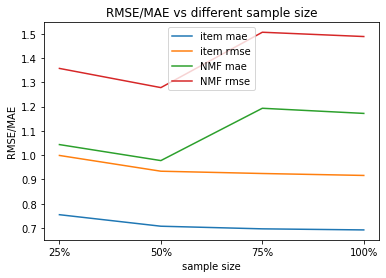

In [99]:
fig, ax = plt.subplots()
ax.plot(sample_size, item_model_mae, label='item mae');
ax.plot(sample_size, item_model_rmse, label='item rmse');
ax.plot(sample_size, NMF_model_mae, label='NMF mae');
ax.plot(sample_size, NMF_model_rmse, label='NMF rmse');
ax.set_title('RMSE/MAE vs different sample size')
ax.set_xlabel('sample size')
ax.set_ylabel('RMSE/MAE')
ax.legend();

- According to the results above, the overall test accuracy of both models change as the sampling size increases.

- For item-based neighborhood model, both test RMSE and MAE decrease(monitonically) as the samping size increases.

- For NMF model, both test RMSE and MAE reach their minimum at 75% sampling size but slightly increase as the sampling size approaches 100%.

### Part 6.6: What about the distribution of accuracy over users or items?

**Explanation:**
- Among the tested sample sizes and error methodologies, there is a relatively uniform distribution of model performance in terms of accuracy, with a momentary convergence at the 75% level. Item based mean absolute error performs the best across each of the tested models, and nonnegative matrix factorization with mean squared error performs the worst across the board. The split between them is relatively constant, again with a short kink improving the error for the NMF models at the 75% range. 


### Part 6.7: How does run-time scale with data size?

In [100]:
sample_size = ['25%', '50%', '75%', '100%']

In [101]:
item_model_fit_time = [item_model_25_fit_time, 
                       item_model_50_fit_time,
                       item_model_75_fit_time, 
                       item_model_100_fit_time]

item_model_test_time = [item_model_25_test_time, 
                        item_model_50_test_time,
                        item_model_75_test_time, 
                        item_model_100_test_time]

In [102]:
NMF_model_fit_time = [NMF_model_25_fit_time, 
                      NMF_model_50_fit_time,
                      NMF_model_75_fit_time, 
                      NMF_model_100_fit_time]

NMF_model_test_time = [NMF_model_25_test_time, 
                       NMF_model_50_test_time,
                       NMF_model_75_test_time, 
                       NMF_model_100_test_time]

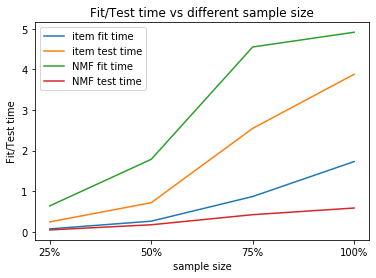

In [103]:
fig, ax = plt.subplots()
ax.plot(sample_size, item_model_fit_time, label='item fit time');
ax.plot(sample_size, item_model_test_time, label='item test time');
ax.plot(sample_size, NMF_model_fit_time, label='NMF fit time');
ax.plot(sample_size, NMF_model_test_time, label='NMF test time');
ax.set_title('Fit/Test time vs different sample size')
ax.set_xlabel('sample size')
ax.set_ylabel('Fit/Test time')
ax.legend();

- According to the results above, both fit time and test time of NMF and item-based models increase as the sampling size increases.

- Especially for NMF, the increase of fit time of NMF is almost proportional to the increase of sampling size.

## Part 7: How does your recommendation system meet your hypothetical objectives? Would you feel comfortable putting these solutions into production at a real company? What would be the potential watch outs?

**Takeaways:**
- Given this narrow-scoped dataset (just users, movies, and ratings), despite its large scale, we are proud of the hypothetical results we saw from our models. The sense-checks we performed in terms of seeing what movies are being recommended for a given user bear out that we are making sensible recommendations of popular movies, which is what we were looking to do from the very start. 
- This workbook answers affirmatively the first business related questions addressed above about whether this model is viable and suits our company's objectives. We know it is effective, we know it makes good recommendations, and we know it has some issues - all production code does. 
- We are happy to put the model into production with a few technical caveats (that we add measures for fairness in representation, add post-model logic for flagging movies that have already been watched or are not appropriate for a given user based on age or the like, etc). 
- As it pertains to our business rules & aims, our current version achieves most of its objectives. We discount the unpopular films (another area for future development), we ensure novelty *within* a recommendation (i.e. won't recommend 'Lion King' twice) but do not ensure novelty at user level by flagging if a user has already seen and rated a film, we also do not have a method of indicating a trending movie and to weight it more heavily in the recommendation - another area for future dev, same story with recommending a partially watched movie - we might want to heavily weight it to remind a user to go back and complete their viewing but we have no way of flagging that with available data. 

## Part 8: Final remarks

**Pros and Cons:**
- The pros:
 1. It makes broadly appealing and sensible predictions/recommendations. 
 2. It trains very quickly even on a laptop, so provided a corporate technical infrastructure, will both scale and be amply prepared for further fine-tuning of hyperparameters in that setting.
 3. We were able to collect a good deal of metadata about the models and the performance of training on data in this format, wherein we can be confident that we have chosen the strongest model for this dataset, and that our framework and pipeline is flexible for the addition of new features and other ways to boost performance (ensembling etc).
- The cons:
 1. There is some repetitive code in the demo here for processing different test/train sets and sampling data, but that repetition wouldn't be required in a production environment - this pipeline will transfer with minimal friction to a purposed data architecture.
 2. There is concern about the convergence of the models on the training data, we see much higher coverage on unseen user data for the model, because the model is less certain about those users. This means that we are either not including a representative sample of users in the train set for the model, or that the model is simply overfitting to the representative sample. We were willing to stomach a degree of overfitting because the predictions still got made in the same rank just with different frequencies - this ought to self correct as the model is re-trained with more and more user data over time. If not , regularization techniques, ensembling with additional models, or adding new features are all ways we can mitigate this effect if need be. 